### 1. Introduction
---

The project will be about predicting the amount of time that it will take to be approved for the permit based on the features that they have. This will be done by using the San Francisco Building Permit Data that was taken from Kaggle. This dataset is all the information that is collected that pertains to the permit issued by the government. These are all general information such as dates, type of permit, costs, and other kinds of needed information. The objectives for this are to create a classification that can be used to predict the amount of days it takes. The kind of algorithm that I plan on using is a Naive Bayes classifier, KNN, and a decision tree to predict that kind of category that it will fall into. These categories will be: Same day, A week, 1-2 weeks, 2 weeks - 1 month, 1-2 months, 2-3 months, and so on. This will be done by using the various features within the dataset as I have a mixture of both numerical and categorical features. From what I were able to find, most of the prediction methods generally had the same accuracy and weren't very good at predicting this. This could be explained by the dataset being very imbalanced where one of the categories was almost 80% of the data. 

### 2. EDA
---

In [2]:
#Import in the necessary libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors
import seaborn as sns

%matplotlib inline

In [3]:
#Read in the csv file
df = pd.read_csv("Building_Permits.csv")

C:\Users\taqua\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (22,32) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
#Check the top of the data to see how it looks
df.head()

,Permit Number,Permit Type,Permit Type Definition,Permit Creation Date,Block,Lot,Street Number,Street Number Suffix,Street Name,Street Suffix,...,Existing Construction Type,Existing Construction Type Description,Proposed Construction Type,Proposed Construction Type Description,Site Permit,Supervisor District,Neighborhoods - Analysis Boundaries,Zipcode,Location,Record ID
0,201505065519,4,sign - erect,05/06/2015,0326,023,140,NaN,Ellis,St,...,3.0,constr type 3,NaN,NaN,NaN,3.0,Tenderloin,94102.0,"(37.785719256680785, -122.40852313194863)",1380611233945
1,201604195146,4,sign - erect,04/19/2016,0306,007,440,NaN,Geary,St,...,3.0,constr type 3,NaN,NaN,NaN,3.0,Tenderloin,94102.0,"(37.78733980600732, -122.41063199757738)",1420164406718
2,201605278609,3,additions alterations or repairs,05/27/2016,0595,203,1647,NaN,Pacific,Av,...,1.0,constr type 1,1.0,constr type 1,NaN,3.0,Russian Hill,94109.0,"(37.7946573324287, -122.42232562979227)",1424856504716
3,201611072166,8,otc alterations permit,11/07/2016,0156,011,1230,NaN,Pacific,Av,...,5.0,wood frame (5),5.0,wood frame (5),NaN,3.0,Nob Hill,94109.0,"(37.79595867909168, -122.41557405519474)",1443574295566
4,201611283529,6,demolitions,11/28/2016,0342,001,950,NaN,Market,St,...,3.0,constr type 3,NaN,NaN,NaN,6.0,Tenderloin,94102.0,"(37.78315261897309, -122.40950883997789)",144548169992


In [5]:
#Check the shape
df.shape

(198900, 43)

In [6]:
#Check how many null values I have
df.isnull().sum()

Permit Number                                  0
Permit Type                                    0
Permit Type Definition                         0
Permit Creation Date                           0
Block                                          0
Lot                                            0
Street Number                                  0
Street Number Suffix                      196684
Street Name                                    0
Street Suffix                               2768
Unit                                      169421
Unit Suffix                               196939
Description                                  290
Current Status                                 0
Current Status Date                            0
Filed Date                                     0
Issued Date                                14940
Completed Date                            101709
First Construction Document Date           14946
Structural Notification                   191978
Number of Existing S

In [7]:
#drop rows of more than 8 missing values
df.dropna(thresh=35, inplace =True)

#return new shape of the dataframe
df.shape

(100587, 43)

In [8]:
#drop unwanted columns
df.drop(columns=['Street Number Suffix', 'Unit', 'Unit Suffix','Structural Notification', 'Completed Date','Structural Notification','Voluntary Soft-Story Retrofit','Fire Only Permit','TIDF Compliance','Site Permit'], inplace = True)


In [9]:
#Put all of these into a date format
df['Permit Creation Date'] = pd.to_datetime(df['Permit Creation Date'])
df['Filed Date'] = pd.to_datetime(df['Filed Date'])
df['Issued Date'] = pd.to_datetime(df['Issued Date'])
df['Current Status Date'] = pd.to_datetime(df['Current Status Date'])
df['Permit Expiration Date'] = pd.to_datetime(df['Permit Expiration Date'])

In [10]:
#New attribute necessary for my prediction
df['Time'] = (df['Issued Date'] - df['Filed Date']) / np.timedelta64(1, 'D')

In [11]:
#Check the df time 
df['Time']

3          253.0
5           22.0
6            0.0
48           0.0
92           0.0
           ...  
198845       0.0
198851    1045.0
198867       0.0
198873       0.0
198874       0.0
Name: Time, Length: 100587, dtype: float64

In [12]:
#Put these dates into bins to check the class distribution
bins_1 = [0,93,183,276,365,df.Time.max()]
bins_2 = [0,1,7,15,31,62,93,124,155,186,365,df.Time.max()]
names_1=['< 3 months', '3-6 months', '6-9 months', '9 months - a year', '1+ year']
names_2=['Same day','< a week','1-2 weeks','2 weeks - 1 month', '1-2 months', '2-3 months', '3-4 months', '4-5 months', '5-6 months', '6 months - a year', '1+ year']

In [13]:
#Now cut these and create a new column for it 
b = pd.cut(df['Time'], bins_1,labels=names_1,include_lowest =False)
c = pd.cut(df['Time'], bins_2,labels=names_2,include_lowest =False)
df['Time2'] = b
df['Time3'] = c

In [14]:
#return statistical data of numerical value columns
df.dtypes

Permit Number                                     object
Permit Type                                        int64
Permit Type Definition                            object
Permit Creation Date                      datetime64[ns]
Block                                             object
Lot                                               object
Street Number                                      int64
Street Name                                       object
Street Suffix                                     object
Description                                       object
Current Status                                    object
Current Status Date                       datetime64[ns]
Filed Date                                datetime64[ns]
Issued Date                               datetime64[ns]
First Construction Document Date                  object
Number of Existing Stories                       float64
Number of Proposed Stories                       float64
Permit Expiration Date         

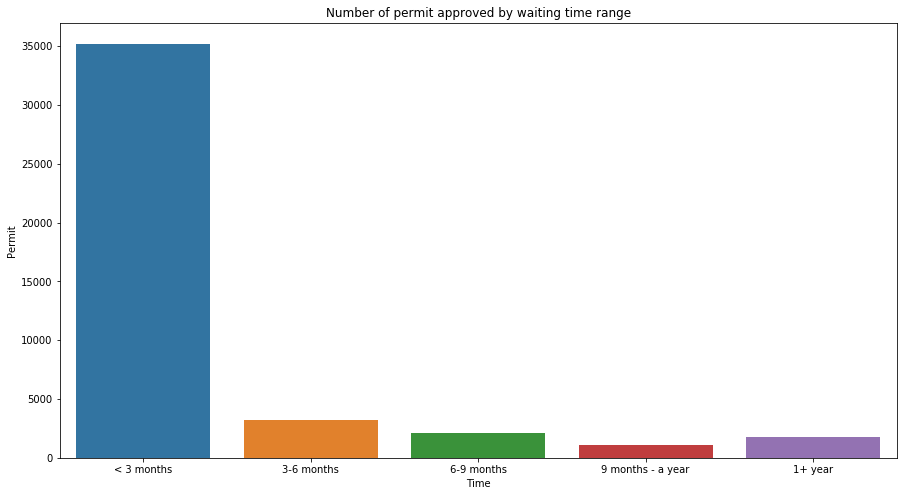

In [40]:
#Check the plot for number of permits approved
plt.figure(2, figsize= (15,8))
sns.countplot(x='Time2',data=df)
plt.xlabel("Time")
plt.ylabel("Permit")
plt.title("Number of permit approved by waiting time range")
plt.show()

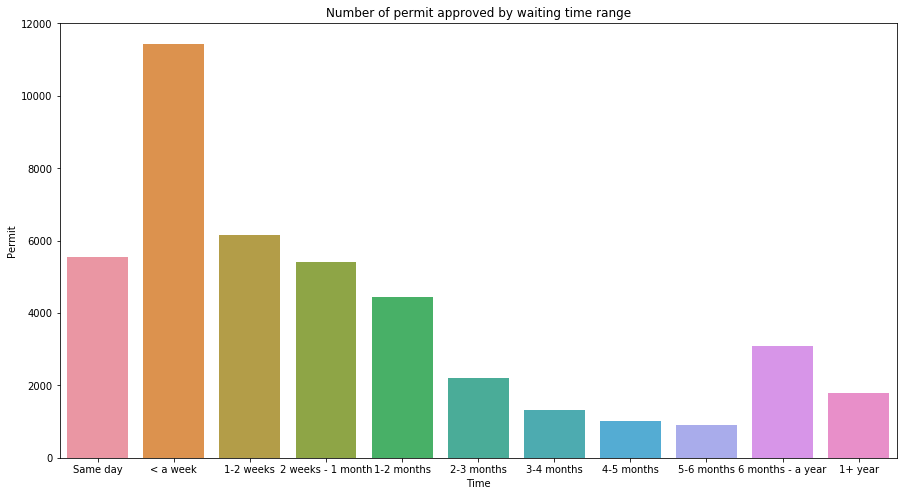

In [41]:
#Check the number of permits approved in time range but zoomed in more
plt.figure(3, figsize= (15,8))
sns.countplot(x='Time3',data=df)
plt.xlabel("Time")
plt.ylabel("Permit")
plt.title("Number of permit approved by waiting time range")
plt.show()

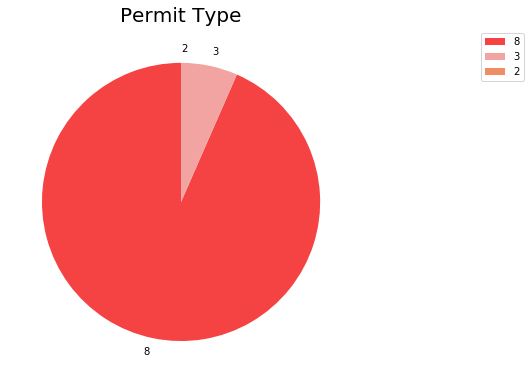

In [42]:
#plot the pie chart for proportion of catefories in Permit Type
labels = df['Permit Type'].value_counts().keys()[:20]
sizes = df['Permit Type'].value_counts().values[:20]
colors = ['#f54242', '#f2a4a2', '#f08d62']

plt.pie(sizes, labels = labels, colors = colors, startangle = 90)
plt.legend(bbox_to_anchor=(1.5,1))

fig = plt.gcf()
fig.set_size_inches(8,8)
plt.title('Permit Type', fontsize=20)
space = plt.gca()
space.title.set_position([0.5, 1])

plt.tight_layout()

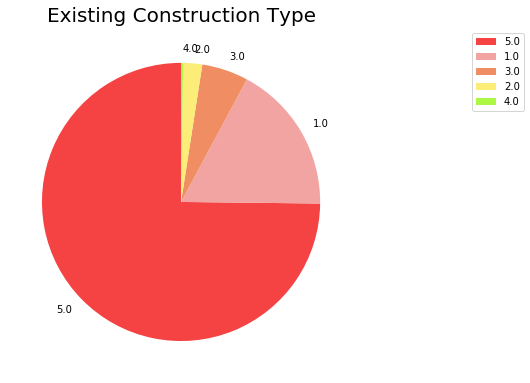

In [43]:
#plot the pie chart for proportion of catefories in Existing Construction Type
labels = df['Existing Construction Type'].value_counts().keys()[:20]
sizes = df['Existing Construction Type'].value_counts().values[:20]
colors = ['#f54242', '#f2a4a2', '#f08d62','#fced79', '#adf745', '#45d9f7', '#2147b0', '#e8d987', '#a293d9','#a564fa', '#e364fa', '#eebcf7'
          ,'#bcf7d9', '#327899', '#fcec00', '#2147b0', '#a3a3a3', '#f6ffc2', '#9c4f1f', '#a67ba4', '#87dde8']

plt.pie(sizes, labels=labels, colors = colors , startangle = 90)
plt.legend(bbox_to_anchor=(1.5,1))

fig = plt.gcf()
fig.set_size_inches(8,8)
plt.title('Existing Construction Type', fontsize=20)
space = plt.gca()
space.title.set_position([0.5, 1])

plt.tight_layout()

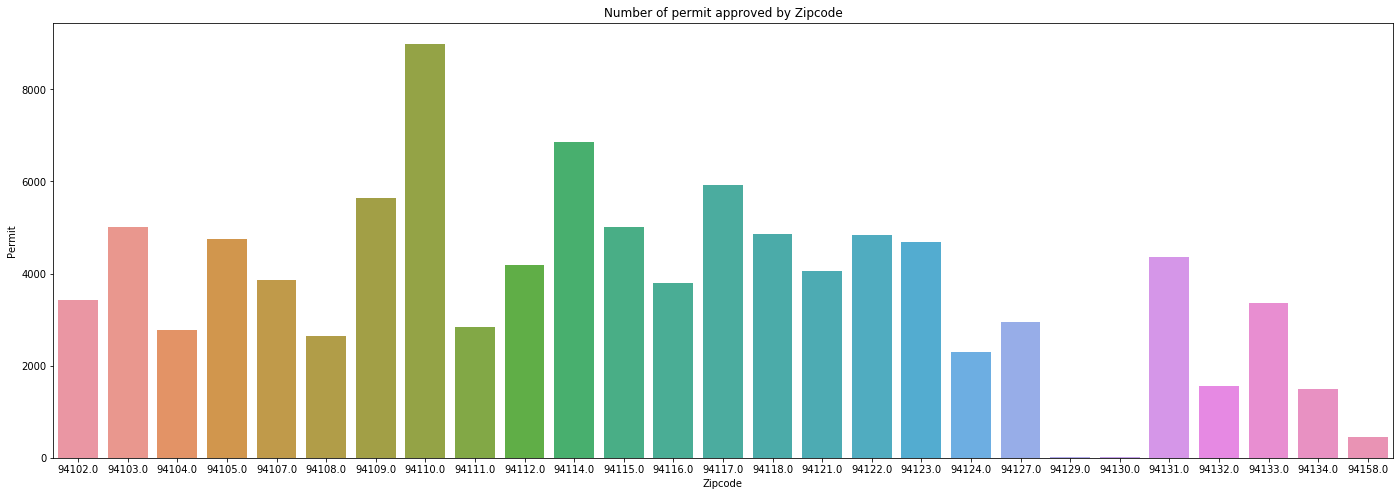

In [44]:
#Check the distribution of zipcodes
b = df['Zipcode'][df['Issued Date'].notnull() == True]
plt.figure(5, figsize= (24,8))
sns.countplot(x=b,data=df)
plt.xlabel("Zipcode")
plt.ylabel("Permit")
plt.title("Number of permit approved by Zipcode")
plt.show()

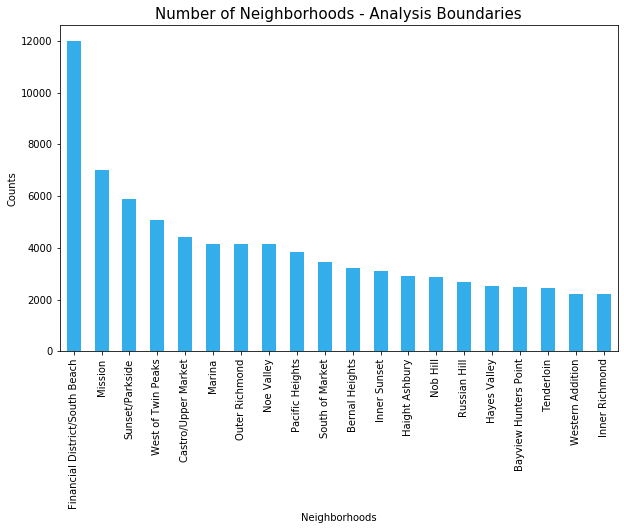

In [45]:
#plot the column chart for proportion of top 20 most common catefories in Neighborhoods - Analysis Boundaries
plt.title("Number of Neighborhoods - Analysis Boundaries", fontsize = 15)
df["Neighborhoods - Analysis Boundaries"].value_counts()[:20].plot(kind = "bar",figsize = (10, 6), color = '#34aeeb')
plt.xlabel("Neighborhoods")
plt.ylabel("Counts")
plt.show()

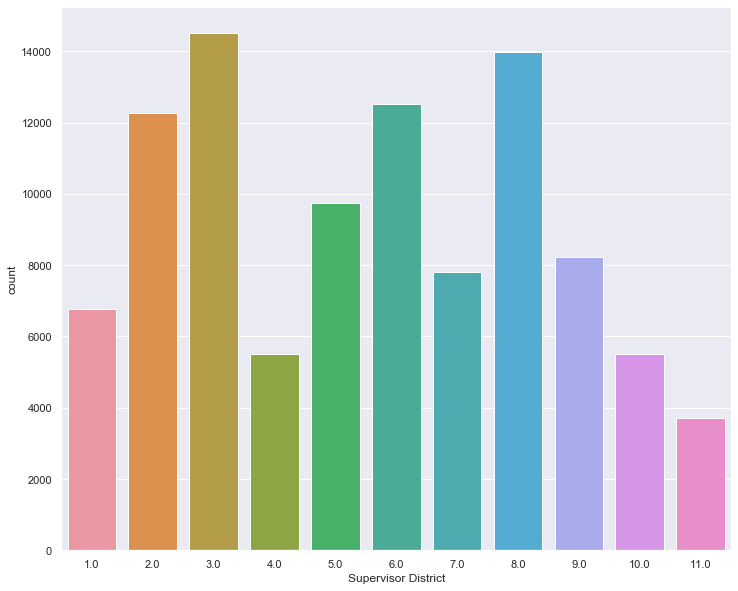

In [46]:
#Histogram of the supervisor districts
plt.figure(figsize=(12,10))

sns.set(style="darkgrid")
sns.countplot(
    data=df,
    x='Supervisor District')

### 3. Predictions
---

Cleanning the data

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import packages and libraries
#setting up initialization

In [3]:
#load the dataset into dataframe "df"
df4 = pd.read_csv("Building_Permits.csv", index_col = None)
df4.head()

C:\Users\VRTS\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (22,32) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Permit Number,Permit Type,Permit Type Definition,Permit Creation Date,Block,Lot,Street Number,Street Number Suffix,Street Name,Street Suffix,...,Existing Construction Type,Existing Construction Type Description,Proposed Construction Type,Proposed Construction Type Description,Site Permit,Supervisor District,Neighborhoods - Analysis Boundaries,Zipcode,Location,Record ID
0,201505065519,4,sign - erect,05/06/2015,0326,023,140,NaN,Ellis,St,...,3.0,constr type 3,NaN,NaN,NaN,3.0,Tenderloin,94102.0,"(37.785719256680785, -122.40852313194863)",1380611233945
1,201604195146,4,sign - erect,04/19/2016,0306,007,440,NaN,Geary,St,...,3.0,constr type 3,NaN,NaN,NaN,3.0,Tenderloin,94102.0,"(37.78733980600732, -122.41063199757738)",1420164406718
2,201605278609,3,additions alterations or repairs,05/27/2016,0595,203,1647,NaN,Pacific,Av,...,1.0,constr type 1,1.0,constr type 1,NaN,3.0,Russian Hill,94109.0,"(37.7946573324287, -122.42232562979227)",1424856504716
3,201611072166,8,otc alterations permit,11/07/2016,0156,011,1230,NaN,Pacific,Av,...,5.0,wood frame (5),5.0,wood frame (5),NaN,3.0,Nob Hill,94109.0,"(37.79595867909168, -122.41557405519474)",1443574295566
4,201611283529,6,demolitions,11/28/2016,0342,001,950,NaN,Market,St,...,3.0,constr type 3,NaN,NaN,NaN,6.0,Tenderloin,94102.0,"(37.78315261897309, -122.40950883997789)",144548169992


In [4]:
#drop rows of more than 8 missing values
df4.dropna(thresh=35, inplace =True)

#return new shape of the dataframe
df4.shape

(100587, 43)

In [5]:
#drop columns with too many missing values
df4.drop(columns=['Street Number Suffix', 'Unit', 'Unit Suffix','Structural Notification', 'Completed Date','Structural Notification','Voluntary Soft-Story Retrofit','Fire Only Permit','TIDF Compliance','Site Permit'], inplace = True)

In [6]:
#drop columns with categorical values
df4.drop(columns=['Permit Type Definition', 'Permit Creation Date', "Block", 'Description', "Lot", "Street Name", "Street Suffix", "Current Status", "Current Status Date", "Filed Date", "Issued Date", "First Construction Document Date", "Existing Use", "Proposed Use", "Existing Construction Type Description", "Proposed Construction Type Description", "Neighborhoods - Analysis Boundaries", "Location"], inplace = True)

In [ ]:
#fill in null values by the mean value of each column
df4.fillna(df4.mean(), inplace = True)

In [ ]:
#Create a new dataframe and have only these 2 columns
df2 = pd.read_csv("Building_Permits.csv", index_col = None)
df2.dropna(thresh=35, inplace =True)
df2 = df2.loc[:, ['Filed Date','Issued Date']] #choose Filed Date and Issued Date columns only

In [ ]:
#Convert these 2 columns into date time
df2['Filed Date'] = pd.to_datetime(df2['Filed Date'])
df2['Issued Date'] = pd.to_datetime(df2['Issued Date'])

In [ ]:
#New attribute necessary for my prediction
df2['Time'] = (df2['Issued Date'] - df2['Filed Date']) / np.timedelta64(1, 'D')

In [ ]:
#Concat these 2 dataframes together
df0=pd.concat([df4, df2], axis=1)

In [ ]:
#Create bins and cut them in a new column called cat_time
df0['cat_time'] = pd.cut(df0.Time, bins = [0,1,7,15,31,62,93,124,155,186,365,1800]
                                      , labels =['Same day', 'Less than a week' ,'1-2 weeks','2 weeks - 1 month', 
                                                 '1-2 months', '2-3 months', '3-4 months', '4-5 months', 
                                                 '5-6 months', '6 months-a year', '1+ year']
                                      , right=False)

df0.head()

In [ ]:
#Create a test dataframe that only has the numerical columns 
dftest = df0[['Permit Type', 'Street Number', 'Number of Existing Stories', 
             'Number of Proposed Stories', 'Estimated Cost', 'Revised Cost', 
            'Proposed Units', 'Existing Construction Type', 'Proposed Construction Type',
            'Supervisor District', 'Zipcode', 'cat_time']]

dftest.columns

In [ ]:
dftest.shape

KNN:
---

In [202]:
#X will have the columns from 0 - 10 
#Y will have only the column cat_time 
X = dftest.iloc[:, 0:11].values #attributes
y = dftest.iloc[:, -1].values #label

In [203]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

In [204]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)
knn.score(X_train, y_train)
y_pred = knn.predict(X_test)

In [205]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
# Summary of the predictions made by the classifier
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
# Accuracy score
from sklearn.metrics import accuracy_score
print('accuracy is',accuracy_score(y_pred,y_test))

                   precision    recall  f1-score   support

          1+ year       0.18      0.27      0.22       373
       1-2 months       0.15      0.16      0.15       901
        1-2 weeks       0.18      0.13      0.15      1516
2 weeks - 1 month       0.17      0.11      0.14      1186
       2-3 months       0.13      0.05      0.07       476
       3-4 months       0.12      0.05      0.07       269
       4-5 months       0.26      0.12      0.17       196
       5-6 months       0.35      0.14      0.20       183
  6 months-a year       0.25      0.19      0.21       598
 Less than a week       0.23      0.18      0.20      2982
         Same day       0.70      0.82      0.76     11438

         accuracy                           0.53     20118
        macro avg       0.25      0.20      0.21     20118
     weighted avg       0.48      0.53      0.50     20118

[[ 101   49   25   30   10    2    4    2   27   50   73]
 [  54  140   79   58   21   11    3    6   30  131  3

Text(89.18, 0.5, 'predicted label')

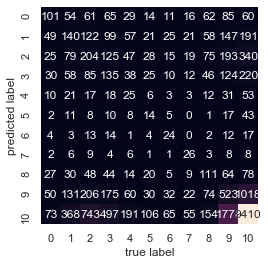

In [207]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')

Naive Bayes
---

In [208]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()

In [209]:
#Using the same data from KNN
gnb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [210]:
y_pred = gnb.predict(X_test)

In [211]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

print("Accuracy score: ", accuracy_score(y_test, y_pred))
print("Recall score: ", recall_score(y_test, y_pred, average = 'weighted'))
print("Precision score: ", precision_score(y_test, y_pred, average = 'weighted'))
print("F1 score: ", f1_score(y_test, y_pred, average = 'weighted'))

Accuracy score:  0.5698876627895417
Recall score:  0.5698876627895417
Precision score:  0.402914500579817
F1 score:  0.4495228750965674


C:\Users\Anthony\Documents\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [167]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
# Summary of the predictions made by the classifier
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
# Accuracy score
from sklearn.metrics import accuracy_score,f1_score
print('accuracy is',accuracy_score(y_pred,y_test))
print("F1 score: ", f1_score(y_test, y_pred, average = 'weighted'))

C:\Users\taqua\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                   precision    recall  f1-score   support

          1+ year       0.00      0.00      0.00       489
       1-2 months       0.00      0.00      0.00      1331
        1-2 weeks       0.97      0.01      0.03      2073
2 weeks - 1 month       1.00      0.00      0.01      1707
       2-3 months       0.00      0.00      0.00       700
       3-4 months       0.00      0.00      0.00       356
       4-5 months       0.00      0.00      0.00       312
       5-6 months       0.00      0.00      0.00       258
  6 months-a year       0.85      0.11      0.20       870
 Less than a week       0.21      0.07      0.10      4257
         Same day       0.58      0.99      0.73     15377

         accuracy                           0.57     27730
        macro avg       0.33      0.11      0.10     27730
     weighted avg       0.52      0.57      0.43     27730

[[    0     0     0     0     0     0     0     0     4    49   436]
 [    0     0     0     0     0     0     0

In [213]:
#Read in the csv file from kaggle that contains the San Francisco Building Permits dataset
#Getting an error for columns 22 and 32 having issues with weird types.
dfpermits = pd.read_csv('Building_Permits.csv')

C:\Users\Anthony\Documents\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (22,32) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [214]:
#Dropping columns that I feel are somewhat unneccessary to my project, have too much missing, 
#or I couldn't understand what the column was for 
dfpermits = dfpermits.drop(['Street Number Suffix', 'Street Suffix', 'Unit', 'Unit Suffix', 
                            'TIDF Compliance', 'Current Status Date', 'Completed Date', 
                            'First Construction Document Date', 'Structural Notification',
                            'Voluntary Soft-Story Retrofit', 'Fire Only Permit', 'Permit Expiration Date',
                            'Site Permit', 'Street Number', 'Street Name', 'Existing Use',
                            'Record ID', 'Existing Units', 'Plansets', 'Proposed Use', 'Proposed Units'], axis = 1)

In [215]:
#Check what columns I have left
dfpermits.columns

Index(['Permit Number', 'Permit Type', 'Permit Type Definition',
       'Permit Creation Date', 'Block', 'Lot', 'Description', 'Current Status',
       'Filed Date', 'Issued Date', 'Number of Existing Stories',
       'Number of Proposed Stories', 'Estimated Cost', 'Revised Cost',
       'Existing Construction Type', 'Existing Construction Type Description',
       'Proposed Construction Type', 'Proposed Construction Type Description',
       'Supervisor District', 'Neighborhoods - Analysis Boundaries', 'Zipcode',
       'Location'],
      dtype='object')

In [216]:
#drop rows of more than 15 missing values
dfpermits.dropna(thresh=22, inplace =True)

#return new shape of the dataframe
dfpermits.shape

(138649, 22)

In [217]:
#Convert this columns to date time
dfpermits['Filed Date'] = pd.to_datetime(dfpermits['Filed Date'])
dfpermits['Issued Date'] = pd.to_datetime(dfpermits['Issued Date'])

In [218]:
#New attribute necessary for my prediction
dfpermits['Time'] = (dfpermits['Issued Date'] - dfpermits['Filed Date']) / np.timedelta64(1, 'D')

In [219]:
#Create bins and cut them in a new column called cat_time
dfpermits['cat_time'] = pd.cut(dfpermits.Time, bins = [0,1,7,15,31,62,93,124,155,186,365,1800]
                                      , labels =['Same day', 'Less than a week' ,'1-2 weeks','2 weeks - 1 month', 
                                                 '1-2 months', '2-3 months', '3-4 months', '4-5 months', 
                                                 '5-6 months', '6 months-a year', '1+ year']
                                      , right=False)

dfpermits.head()

,Permit Number,Permit Type,Permit Type Definition,Permit Creation Date,Block,Lot,Description,Current Status,Filed Date,Issued Date,...,Existing Construction Type,Existing Construction Type Description,Proposed Construction Type,Proposed Construction Type Description,Supervisor District,Neighborhoods - Analysis Boundaries,Zipcode,Location,Time,cat_time
3,201611072166,8,otc alterations permit,11/07/2016,0156,011,repair dryrot & stucco at front of bldg.,complete,2016-11-07,2017-07-18,...,5.0,wood frame (5),5.0,wood frame (5),3.0,Nob Hill,94109.0,"(37.79595867909168, -122.41557405519474)",253.0,6 months-a year
5,201706149344,8,otc alterations permit,06/14/2017,4105,009,evac maps,issued,2017-06-14,2017-07-06,...,1.0,constr type 1,1.0,constr type 1,10.0,Potrero Hill,94107.0,"(37.75922331346539, -122.39170402628598)",22.0,2 weeks - 1 month
6,201706300814,8,otc alterations permit,06/30/2017,1739,020,re-roofing,complete,2017-06-30,2017-06-30,...,5.0,wood frame (5),5.0,wood frame (5),5.0,Inner Sunset,94122.0,"(37.764145640138565, -122.46875112470363)",0.0,Same day
24,201708084249,8,otc alterations permit,08/08/2017,0542,039,re-roofing,issued,2017-08-08,2017-08-08,...,5.0,wood frame (5),5.0,wood frame (5),2.0,Marina,94123.0,"(37.79739093461306, -122.43127133823367)",0.0,Same day
25,201708165014,8,otc alterations permit,08/16/2017,1824,006,re-roofing,issued,2017-08-16,2017-08-16,...,5.0,wood frame (5),5.0,wood frame (5),4.0,Sunset/Parkside,94122.0,"(37.76052279949518, -122.4879889739165)",0.0,Same day


In [220]:
#Check the class distribution
dfpermits['cat_time'].value_counts()

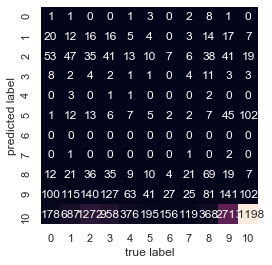

In [224]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [225]:
#THIS IS THE PART WHERE I AM TRYING TO USE TEXT FOR MULTINOMIAL NB
#This will use most of the features 
import string
dfpermits['Description'] = dfpermits.Description.map(lambda x: x.lower().translate(str.maketrans('','', string.punctuation)))

In [226]:
#Create a new df 
dfpermits2 = dfpermits[['Permit Type Definition', 'Description', 'Block', 'Lot', 'Number of Existing Stories', 'Number of Proposed Stories',
                        'Existing Construction Type Description', 'Proposed Construction Type Description', 
                        'Neighborhoods - Analysis Boundaries', 'Zipcode', 'cat_time']]

In [227]:
dfpermits2["text"] = dfpermits2["Permit Type Definition"] + " " + dfpermits2["Description"] + " " + dfpermits2['Block'].astype(str)\
                    + " " + dfpermits2['Lot'].astype(str) + " " + dfpermits2['Existing Construction Type Description']\
                    + " " + dfpermits2['Proposed Construction Type Description'] + " " + dfpermits2['Neighborhoods - Analysis Boundaries']\
                    + " " + dfpermits2['Zipcode'].astype(str) + " " + dfpermits2['Number of Proposed Stories'].astype(str) + " " + dfpermits2['Number of Existing Stories'].astype(str)

C:\Users\Anthony\Documents\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [228]:
#USING ARRAYS
XMNB = dfpermits2['text']
yMNB = dfpermits2['cat_time']

In [229]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(XMNB, yMNB, test_size=0.2,  random_state = 0)

In [230]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
train_features = vectorizer.fit_transform(X_train)
test_features = vectorizer.transform(X_test)

In [231]:
from sklearn.naive_bayes import MultinomialNB

naive_bayes = MultinomialNB()
naive_bayes.fit(train_features, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [232]:
y_pred = naive_bayes.predict(test_features)

In [233]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

print("Accuracy score: ", accuracy_score(y_test, y_pred))
print("Recall score: ", recall_score(y_test, y_pred, average = 'weighted'))
print("Precision score: ", precision_score(y_test, y_pred, average = 'weighted'))
print("F1 score: ", f1_score(y_test, y_pred, average = 'weighted'))

Accuracy score:  0.565452578434908
Recall score:  0.565452578434908
Precision score:  0.5145389014180451
F1 score:  0.42896953705075963


C:\Users\Anthony\Documents\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [236]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
# Summary of the predictions made by the classifier
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
# Accuracy score
from sklearn.metrics import accuracy_score
print('accuracy is',accuracy_score(y_pred,y_test))

                   precision    recall  f1-score   support

          1+ year       0.00      0.00      0.00       489
       1-2 months       0.00      0.00      0.00      1331
        1-2 weeks       0.96      0.01      0.03      2073
2 weeks - 1 month       1.00      0.00      0.01      1707
       2-3 months       0.00      0.00      0.00       700
       3-4 months       0.00      0.00      0.00       356
       4-5 months       0.00      0.00      0.00       312
       5-6 months       0.00      0.00      0.00       258
  6 months-a year       0.85      0.11      0.20       870
 Less than a week       0.21      0.06      0.09      4257
         Same day       0.58      0.99      0.73     15377

         accuracy                           0.57     27730
        macro avg       0.33      0.11      0.10     27730
     weighted avg       0.51      0.57      0.43     27730

[[    0     0     0     0     0     0     0     0     4    46   439]
 [    0     0     0     0     0     0     0

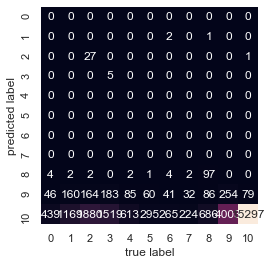

In [235]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

Decision Tree (For numerical values)
---

In [173]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import packages and libraries
#setting up initialization

In [174]:
# Bagged Decision Trees for Classification
from pandas import read_csv
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [175]:
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict

In [176]:
#label encoding
for column in dfpermits.columns:
    le = LabelEncoder()
    dfpermits[column] = le.fit_transform(dfpermits[column].astype(str))

In [177]:
seed = 7
kfold = KFold(n_splits=10, random_state=seed)
cart = DecisionTreeClassifier()
num_trees = 100

C:\Users\Anthony\Documents\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [178]:
model = BaggingClassifier(base_estimator=cart, n_estimators=num_trees, random_state=seed)
results = cross_val_score(model, X, y, cv=kfold)

In [179]:
print(results.mean())

0.5583327714268674


In [181]:
# Random Forest Classification
from pandas import read_csv
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
num_trees = 100
max_features = 3
kfold = KFold(n_splits=10, random_state=7)
model = RandomForestClassifier(n_estimators=num_trees, max_features=max_features)
results = cross_val_score(model, X, y, cv=kfold)
print(results.mean())

C:\Users\Anthony\Documents\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.5570602732009994


In [184]:
model = RandomForestClassifier(n_estimators=100)
model.fit(X, y)
print(model.feature_importances_)

[0.04389836 0.27135763 0.0360191  0.03659784 0.16601553 0.20004423
 0.08122525 0.00895924 0.00877907 0.06251929 0.08458446]


### 4. Conclusions
---

The evaluation metrics used in this project would be the mix of accuracy, precision, recall, and F-1 score: I chose to measure the effectiveness of a good prediction using F-1 score, because the class distribution of waiting time is highly imbalanced. Moreover, the algorithm developed for this dataset is based on buildings' features to determine average waiting time, so information about both Precision and Recall is necessary to understand how precise the algorithm is as well as the fraction of True Positive events has been successfully recognized.

The methods that I have chosen to divide the data is the test_train_split from scikit learn. This method was used for KNN, Gaussian NB, and Multinomial NB. I chose these methods as they are the most simple in splitting up the data and what I are most used to. For the Decision Tree and Random Forest Tree, I used a KFold cross validation to split up the data because of how they did it in the practical ML problem. 

The top 5 most important attributes for the dataset were street number, estimated cost, revised cost, zipcode, and proposed units. To us, street number doesn't really make sense because of the fact that street number doesn't really mean anything without a street name. This is because street numbers can be repeated multiple times. For estimated cost and revised cost, these are pretty important due to the fact that these can be used to help the approval process when someone has to plan their project out. The government needs to see that there's a plan before handing out permits and by having both these costs down, it could potentially make it faster. Zipcode is important because of certain locations potentially having a higher chance in getting approved much faster. For example, what if an area such as downtown gets more building permits due to it having more development since it's such a popular area. Proposed units is also an important feature because proposed units could affect their building permit issue date due to things such as building another floor or an entire building could take much longer to approve compared to something like just putting a sign up on their property. 

From the 3 models, I can see that the accuracy for each one isn't really good. One thing to state about this is that all the models would use numerical data except for Multinomial NB. The best one that I had was the Multinomial Naive Bayes one but only by 0.5. This shows that the models weren't really good at predicting but this could also be due to the imbalance within the dataset. If I didn't spread it out, the classifiers would predict at almost 97% for each of the classifiers and I felt this wasn't accurate as I aren't predicting the other classes within the dataset. From what I can see, each accuracy score for the different methods are hovering between .53 - .56. This means that the models can predict about half the testing correctly. When looking at the classification matrix however, KNN was able to predict all the types of classes while things like GaussianNB missed a couple and had lower accuracy in terms of accuracy. When running the Multinomial Naive Bayes, it only predicted 4 of the classes but this could be due to how I cleaned the data for that problem. I also incorporated more columns into it and converted them all to string in order to read it into the model. For the decision tree and random forest models, the accuracy for both were around the same at .558 and .557 respectively with random forest being slightly lower. The columns used in this were the same as KNN and the GaussianNB models. Due to the way that the data is split, I didn't know how to do the classification matrix and confusion matrix as the data isn't really split up. When trying to look at a visualization for a confusion matrix for NB and KNN models, it's somewhat hard to visualize it as the models don't do a very good job at predicting. In both KNN and Naive Bayes models, the F-1 Scores are both around 0.43. It may indicates that the model is not accurate.

There really weren't many advantages to each model in terms of accuracy because of how they all predicted the same. However, KNN did have more variety in the classes they predicted. F-1 score is used to ensure the accuracy I find is correct. Another thing that both KNN and NB does better than the decision and random forest tree is that it is both simple and very fast. When running the decision and random forest tree, it took my machine quite awhile to run the models. 

For improvements, I feel as though there was a lot that I could've changed. For example, I think that I could’ve done Naive bayes in a much better way. For example, if I did it by hand and did all the calculations manually, I could’ve probably done something where I could’ve used both the integers and string in the data set. Another thing that I could improve on too is the way I cleaned my data as I have eliminated a lot of the other permit types in order to not have to fill in values because things like the columns where its strings can’t be filled. Another thing that I could've done is to try and standardize the data cleansing as each method had different values dropped and replaced. Something standard could've helped us compare much better. A third thing that I wish I could've done is to explore more into other complex models to predict. 

### 5. Deployment
---

The model isn't very useful for the citizens and companies that are looking to get an estimate of the amount of time it would take to get their building permit issued. This is mostly due to the fact that the accuracy for prediction isn't very good and that the dataset also had a lot of problems with imbalance. This model's value would be measured based on how accurate the bins were when comparing the prediction vs the actual because people will only care about how well the model can predict based on information fed to it. I think that this model should be deployed on the website after someone puts in their information for an actual permit in order to get an estimate of how long it would take. This way, people aren't just randomly putting in information to get a guess and have to put in real information that they would've used on an actual application. I think that they should collect other data such as if there isn't an increase in the proposed units, to just put a 0 in there. They need to make it mandatory so that most of the null values within the dataset are not left null but rather put in with a 0 if it's an empty lot of there's nothing changed with it rather than have it null as I can't sift through each row guessing if there's actual change or not. Another thing that I think should be recorded is potentially the estimated length of the project as this could be useful in determining time issued because longer projects could take more time to review. Another type of data that should be collected is to increase some of the variety of construction type and permit type to help differentiate some of the types. I think that this model should be updated about every half year to a full year because within those times, there's a lot of data that can be collected because people will be doing renovations year round and will need a permit for that.

### 6. Challenges
---

The biggest challenge that I faced was with the dataset. When cleaning, I had to be careful with what I did with it because if I dropped too much, I could end up deleting a lot of valuable data. Another thing with cleaning was that I had to be careful with how I would replace certain values as it wouldn’t make much sense to replace with things like a mean or mode. the dataset also has an imbalance of data where the majority of the time that it took to file and receive the permit was under a week. Almost 90% of the data fell in that region, causing a major issue when trying to train the machine as they would only predict that class every time and not the others. 

Challenges that I had with the algorithms were figuring out what I could implement. I were planning on doing something like trying to predict the days that it would take to obtain a permit but there were no correlations within the data. Therefore, I felt like I couldn't really use linear regression as it wouldn't be effective at all. This would lead us to trying different kinds of classification problems. For us, figuring out what kind of classifications I could do and with what features were also a bit difficult. Another part was the coding aspect of this project. I ran into many errors when trying to code the Naive Bayes because I didn’t know how to try and fit all the features that I wanted into something like multinomial bayes. One way that this could be solved is by manually coding multiple functions to calculate the probabilities of the features given certain conditions. 

A major issue I had with the algorithms is transforming data into the appropriate formats that are compatible with the input of the Decision Tree algorithm. The algorithm accepts inputs with numerical values only, while the columns I chose to pass on into the algorithm contain a mix of numerical, categorical, and date-time data. With that being said, I ran into the issues of converting columns into numerical format. I are continuing to find out possible approaches and try them on the data, including the approaches of mapping, encoding, or using pre-processing packages. The same thing would happen for Naive Bayes where the data where both numerical and strings, causing it to be difficult to transform the data in order to take in all the features.